**Inventory Optimization and Sustainability Analysis**

**Objectives:**

* Minimize waste by optimizing inventory levels.
* Identify the most efficient purchasing strategies based on sales, procurement, and inventory data.
* Evaluate product sales performance to formulate a sustainable inventory management approach.

**1. Data Preprocessing:**  
* Consolidate all CSV files into a unified master dataset.  
* Screen for any missing or erroneous entries.  
* Standardize date formats for consistent time series analysis.

**2. Inventory Analysis:**
* Assess inventory status at the year's start and end using BegInvFINAL12312016.csv and EndInvFINAL12312016.csv.  
* Pinpoint products with the highest and lowest inventory presence.


**3. Sales Analysis:**
* Examine SalesFINAL12312016.csv to identify bestsellers and products with sluggish sales.
* Analyze sales trends over time, considering variables such as sales quantity, sales price, and date.


**4. Purchasing Analysis:**
* Evaluate procurement activities using PurchasesFINAL12312016.csv and InvoicePurchases12312016.csv.
* Investigate purchase volumes from different suppliers, procurement costs, and supply chain processes.

**5. Optimal Stock Level Calculation:**
* Determine the optimal stock level for each product by leveraging sales, procurement, and inventory data.
* Propose stock levels tailored to the sales velocity of products and supply lead times.

**Conclusion:**  
The insights derived from these analyses will provide recommendations for managing inventory in a more efficient and sustainable manner, aiming to cut costs and prevent overstocking and waste.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading datasets
purchase_prices = pd.read_csv('/kaggle/input/inventory-analysis-case-study/2017PurchasePricesDec.csv')
beg_inv = pd.read_csv('/kaggle/input/inventory-analysis-case-study/BegInvFINAL12312016.csv')
end_inv = pd.read_csv('/kaggle/input/inventory-analysis-case-study/EndInvFINAL12312016.csv')
invoice_purchases = pd.read_csv('/kaggle/input/inventory-analysis-case-study/InvoicePurchases12312016.csv')
purchases = pd.read_csv('/kaggle/input/inventory-analysis-case-study/PurchasesFINAL12312016.csv')
sales = pd.read_csv('/kaggle/input/inventory-analysis-case-study/SalesFINAL12312016.csv')


In [3]:
print("purchase_prices Columns:")
print(purchase_prices.columns.tolist())

print("\nbeg_inv Columns:")
print(beg_inv.columns.tolist())

print("\nend_inv Columns:")
print(end_inv.columns.tolist())

print("\ninvoice_purchases Columns:")
print(invoice_purchases.columns.tolist())

print("\npurchases Columns:")
print(purchases.columns.tolist())

print("\nsales Columns:")
print(sales.columns.tolist())

purchase_prices Columns:
['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification', 'PurchasePrice', 'VendorNumber', 'VendorName']

beg_inv Columns:
['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'startDate']

end_inv Columns:
['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'endDate']

invoice_purchases Columns:
['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate', 'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval']

purchases Columns:
['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber', 'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification']

sales Columns:
['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity', 'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification', 'ExciseTax', 'VendorNo', 'VendorName']


In [4]:
# Checking for missing data in each dataset
datasets = [purchase_prices, beg_inv, end_inv, invoice_purchases, purchases, sales]
dataset_names = ["purchase_prices", "beg_inv", "end_inv", "invoice_purchases", "purchases", "sales"]

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]
    
    if not non_zero_missing_values.empty:
        print(f"\nMissing values in {name}:")
        print(non_zero_missing_values)



Missing values in purchase_prices:
Description    1
Size           1
Volume         1
dtype: int64

Missing values in end_inv:
City    1284
dtype: int64

Missing values in invoice_purchases:
Approval    5169
dtype: int64

Missing values in purchases:
Size    3
dtype: int64


Handling missing values is a pivotal step in our data analysis journey. Different data segments might demand distinct strategies. Let's collaboratively address each dataset and decide on the most appropriate course of action:

**purchase_prices:**
* **Description, Size, and Volume:** There's a limited number of missing entries here. We have a few options: removing these specific rows, or, for a more informed approach, substituting these gaps with the most commonly observed value (mode). We'll go with removing these rows  

**end_inv:**
* City: An immediate solution could be to replace the missing 'City' entries with the most frequently occurring city (mode). However, if our 'Store' column has location insights, we might consider using it for a more informed fill. If neither works, marking them as 'Unknown' might be our best bet. We'll try our chances with using 'Store' column.   

**invoice_purchases:**
* Approval: If we interpret 'Approval' as a binary indicator (e.g., Approved/Not Approved), the absences might hint that the status of these invoices hasn't been decided. We can categorize them as 'Pending' or 'Unknown' for clarity.  

**purchases:**
* Size: Mirroring our strategy with 'purchase_prices', we can discard these few rows.

In [5]:
# Handling missing values for purchase_prices dataset
cols_to_check = ['Description', 'Size', 'Volume']
for col in cols_to_check:
    purchase_prices = purchase_prices[purchase_prices[col].notna()]

# Handling missing values for end_inv dataset
if end_inv['Store'].nunique() == end_inv['City'].nunique():
    city_store_mapping = end_inv[['Store', 'City']].drop_duplicates().set_index('Store').to_dict()['City']
    end_inv['City'] = end_inv['City'].fillna(end_inv['Store'].map(city_store_mapping))
else:
    end_inv['City'].fillna('Unknown', inplace=True)

# Handling missing values for invoice_purchases dataset
invoice_purchases['Approval'].fillna('Pending', inplace=True)

# Handling missing values for purchases dataset
purchases = purchases[purchases['Size'].notna()]

datasets = [purchase_prices, beg_inv, end_inv, invoice_purchases, purchases, sales]
dataset_names = ["purchase_prices", "beg_inv", "end_inv", "invoice_purchases", "purchases", "sales"]

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]
    
    if not non_zero_missing_values.empty:
        print(f"\nMissing values in {name}:")
        print(non_zero_missing_values)
    else:
        print(f"\nNo missing values in {name}.")



No missing values in purchase_prices.

No missing values in beg_inv.

No missing values in end_inv.

No missing values in invoice_purchases.

No missing values in purchases.

No missing values in sales.


**2. Inventory Analysis:**

In [6]:
# Grouping by Brand and Description and summarize inventory for beginning of the year
beg_summary = beg_inv.groupby(['Brand', 'Description'])['onHand'].sum().sort_values(ascending=False)

# Grouping by Brand and Description and summarize inventory for end of the year
end_summary = end_inv.groupby(['Brand', 'Description'])['onHand'].sum().sort_values(ascending=False)

# Identifying top 5 products at the beginning and end of the year
top_5_beg = beg_summary.head(5)
top_5_end = end_summary.head(5)

# Identifying bottom 5 products at the beginning and end of the year
bottom_5_beg = beg_summary.tail(5)
bottom_5_end = end_summary.tail(5)

print("Top 5 products at the beginning of the year:\n", top_5_beg)
print("\nTop 5 products at the end of the year:\n", top_5_end)
print("\nBottom 5 products at the beginning of the year:\n", bottom_5_beg)
print("\nBottom 5 products at the end of the year:\n", bottom_5_end)

Top 5 products at the beginning of the year:
 Brand  Description               
4261   Capt Morgan Spiced Rum        15499
8068   Absolut 80 Proof              15341
3876   Smirnoff 80 Proof             14829
3545   Ketel One Vodka               14499
6879   Maurice's Mentholated Mint    14180
Name: onHand, dtype: int64

Top 5 products at the end of the year:
 Brand  Description            
3545   Ketel One Vodka            16770
4261   Capt Morgan Spiced Rum     16769
8111   Smirnoff 80 Proof          16242
8068   Absolut 80 Proof           15608
1233   Jack Daniels No 7 Black    15047
Name: onHand, dtype: int64

Bottom 5 products at the beginning of the year:
 Brand  Description                 
42676  Kistler Chard Sonma Mountain    0
34693  Valley of the Moon Chard        0
42710  Pommery Pink Pop Rose           0
22647  Guillaume Vrignaud Chablis 1    0
21283  J Pierre Chablis Le Forneaux    0
Name: onHand, dtype: int64

Bottom 5 products at the end of the year:
 Brand  Descriptio

**Insights:**  

**Top Products:**
* "Ketel One Vodka" emerged as the top product by the end of the year, even though it was in the 4th position at the beginning. This could imply an increased demand or higher restocking levels for this product during the year.
* "Capt Morgan Spiced Rum", initially the highest in inventory at the start of the year, narrowly missed the top position by a single unit by the year's end.
* "Smirnoff 80 Proof" seems to have undergone a brand update or rebranding, as the brand number changed from 3876 to 8111 during the year. Despite this, its popularity remained consistent.
* "Absolut 80 Proof" held steady, only dropping one rank from the beginning to the end of the year.
* A new entrant, "Jack Daniels No 7 Black", made its way into the top 5 by the end of the year, replacing "Maurice's Mentholated Mint" from the beginning of the year's list.

**Bottom Products:**
* It's alarming to see products with zero inventory both at the beginning and the end of the year. It's possible that these items either never had stock during the entire year, or they had stock that was completely sold out and never replenished.
* There isn't a significant overlap between the products in the bottom 5 of both lists, indicating that inventory for low-stock items could be fluctuating throughout the year.
* The presence of wines and niche products among the bottom lists suggests that these might be specialty items with selective demand or limited supply.

**Inventory Management Observations:**
* **The overall high consistency among the top products suggests steady demand and effective inventory replenishment strategies for popular items.**
* However, **the consistent zero counts at both year start and end for certain products indicate potential issues in inventory management or procurement**. It may be worthwhile to review the demand for these products and determine if it makes business sense to continue carrying them or if there might be supply chain issues preventing their restocking.

**3. Sales Analysis**

In [7]:
# Finding the best-selling products
best_selling_products = sales.groupby(['Brand', 'Description']).agg({'SalesQuantity': 'sum'}).sort_values(by='SalesQuantity', ascending=False).head(10)
print(f"Best selling ten products:\n{best_selling_products}\n")

# Finding the slow-moving products
slow_moving_products = sales.groupby(['Brand', 'Description']).agg({'SalesQuantity': 'sum'}).sort_values(by='SalesQuantity', ascending=True).head(10)
print(f"Slow-moving ten products:\n{slow_moving_products}")

Best selling ten products:
                                    SalesQuantity
Brand Description                                
8111  Smirnoff 80 Proof                     28544
1892  Yukon Jack                            23121
4261  Capt Morgan Spiced Rum                20226
3606  Smirnoff Raspberry Vodka              19200
5111  Dr McGillicuddy's Mentholmnt          18411
3837  Skyy Vodka                            14057
4135  Smirnoff Blueberry Vodka              12477
4157  Smirnoff Green Apple Vodka            12102
3545  Ketel One Vodka                       11883
8068  Absolut 80 Proof                      11189

Slow-moving ten products:
                                    SalesQuantity
Brand Description                                
25727 Chappellet Cab Svgn Pritchrd              1
23110 Duckhorn Estates Merlot                   1
2505  Bowmore Legend Single Malt                1
1043  Jim Beam Gift Pak                         1
23109 DeLille Cellars Chaleur Blnc            

<Axes: title={'center': 'Sales Quantity Over Time'}, xlabel='SalesDate'>

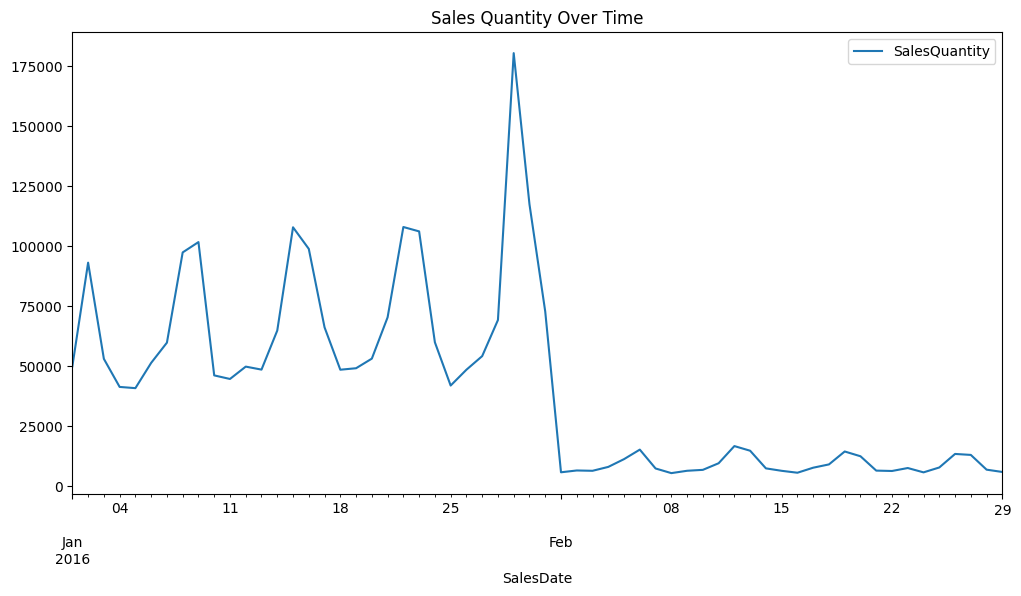

In [8]:
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])
sales_quantity_trend = sales.groupby('SalesDate').agg({'SalesQuantity': 'sum'})
sales_quantity_trend.plot(figsize=(12, 6), title='Sales Quantity Over Time')


<Axes: title={'center': 'Average Sales Price Over Time'}, xlabel='SalesDate'>

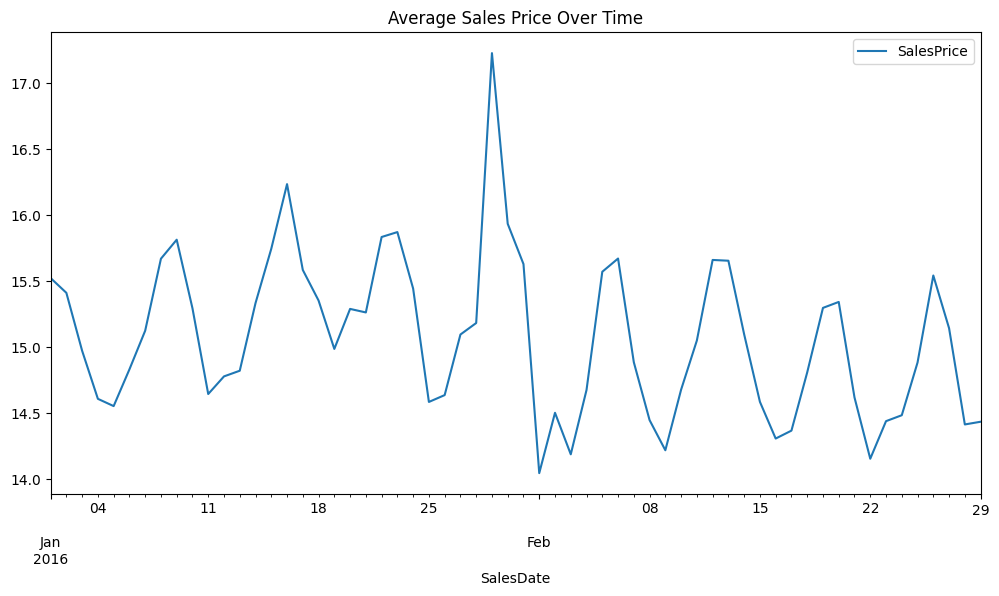

In [9]:
avg_price_trend = sales.groupby('SalesDate').agg({'SalesPrice': 'mean'})
avg_price_trend.plot(figsize=(12, 6), title='Average Sales Price Over Time')


1. **There's a cyclical nature to the sales quantities, which might hint at weekly patterns or trends.**  
1. **A significant peak is noticed around January 25th; this could be attributed to specific events, promotions, or even seasonal demands.** However, as we transition into February, there's a noticeable decline in sales, which then appears to stabilize as the month progresses.
1. **Spirits like "Smirnoff 80 Proof" emerge as the top sellers, reflecting a steady demand.** On the other hand, several products are moving slowly, indicating limited sales. As these products vary in type and brand, a strategic review might be necessary to decide on their continued stocking.

**4. Purchasing Analysis**

In [10]:
vendor_purchase_volume = invoice_purchases.groupby('VendorName').agg({'Quantity': 'sum'}).sort_values(by='Quantity', ascending=False)
print("Top 10 Vendors by Purchase Volume:\n", vendor_purchase_volume.head(10))


Top 10 Vendors by Purchase Volume:
                              Quantity
VendorName                           
DIAGEO NORTH AMERICA INC      5459788
JIM BEAM BRANDS COMPANY       2737165
MARTIGNETTI COMPANIES         2637275
CONSTELLATION BRANDS INC      2325892
E & J GALLO WINERY            1858260
PERNOD RICARD USA             1647558
BACARDI USA INC               1427075
SAZERAC CO INC                1417727
M S WALKER INC                1372841
ULTRA BEVERAGE COMPANY LLP    1077527


In [11]:
vendor_purchase_cost = purchases.groupby('VendorName').agg({'PurchasePrice': 'sum'}).sort_values(by='PurchasePrice', ascending=False)
print("Top 10 Vendors by Purchase Cost:\n", vendor_purchase_cost.head(10))


Top 10 Vendors by Purchase Cost:
                              PurchasePrice
VendorName                                
DIAGEO NORTH AMERICA INC        3919293.52
JIM BEAM BRANDS COMPANY         2445075.37
PERNOD RICARD USA               2002210.70
MARTIGNETTI COMPANIES           1954748.37
ULTRA BEVERAGE COMPANY LLP      1328577.74
CONSTELLATION BRANDS INC        1316920.86
BACARDI USA INC                 1309369.34
E & J GALLO WINERY              1179960.50
BROWN-FORMAN CORP               1089218.08
M S WALKER INC                   979018.30


**Top Vendors by Purchase Cost:**
* DIAGEO NORTH AMERICA INC stands out as the top vendor with the highest purchase cost, amounting to 3,919,293.52 US dollars.
* The following two vendors, 'JIM BEAM BRANDS COMPANY' and 'PERNOD RICARD USA', have notable purchase costs of 2,445,075.37 and 2,002,210.70, respectively.
* **It's interesting to see that the top 10 vendors have a significant difference in their purchase costs, with 'DIAGEO NORTH AMERICA INC' nearly leading by a margin of 1.5 million usd from the vendor in the second position.**

In [12]:
# Converting PODate and ReceivingDate columns to datetime
purchases['PODate'] = pd.to_datetime(purchases['PODate'], errors='coerce')
purchases['ReceivingDate'] = pd.to_datetime(purchases['ReceivingDate'], errors='coerce')

# Checking if there are any null values after conversion
if purchases['PODate'].isnull().any() or purchases['ReceivingDate'].isnull().any():
    print("There are invalid date entries in the dataset. Please review the data.")
else:
    purchases['SupplyDuration'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days
    average_supply_duration = purchases['SupplyDuration'].mean()
    print("Average Supply Duration (in days):", average_supply_duration)



Average Supply Duration (in days): 7.620737197630656


In [13]:
purchases['InvoiceDate'] = pd.to_datetime(purchases['InvoiceDate'])
purchases['PayDate'] = pd.to_datetime(purchases['PayDate'])
purchases['PaymentDuration'] = (purchases['PayDate'] - purchases['InvoiceDate']).dt.days

average_payment_duration = purchases['PaymentDuration'].mean()
print("Average Payment Duration (in days):", average_payment_duration)


Average Payment Duration (in days): 35.658806366863914



**Supply and Payment Durations:**. 
* On average, it takes approximately 7.62 days for the supply process, which indicates a relatively quick turnaround for receiving products after placing an order.
* **However, the payment duration averages around 35.66 days. This could mean that there might be longer credit terms agreed upon with the vendors or there might be some delay in the payment process.**  


In [14]:
reduced_purchases = purchases[['VendorName', 'PurchasePrice']]
top_vendors = reduced_purchases.groupby('VendorName').sum()['PurchasePrice'].nlargest(10)
print(top_vendors)



VendorName
DIAGEO NORTH AMERICA INC       3919293.52
JIM BEAM BRANDS COMPANY        2445075.37
PERNOD RICARD USA              2002210.70
MARTIGNETTI COMPANIES          1954748.37
ULTRA BEVERAGE COMPANY LLP     1328577.74
CONSTELLATION BRANDS INC       1316920.86
BACARDI USA INC                1309369.34
E & J GALLO WINERY             1179960.50
BROWN-FORMAN CORP              1089218.08
M S WALKER INC                  979018.30
Name: PurchasePrice, dtype: float64


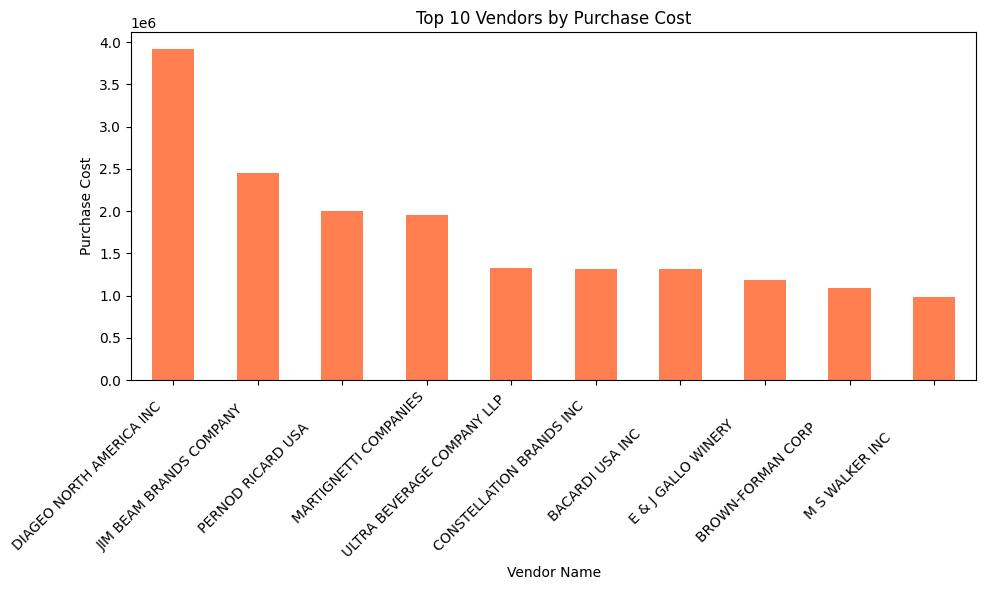

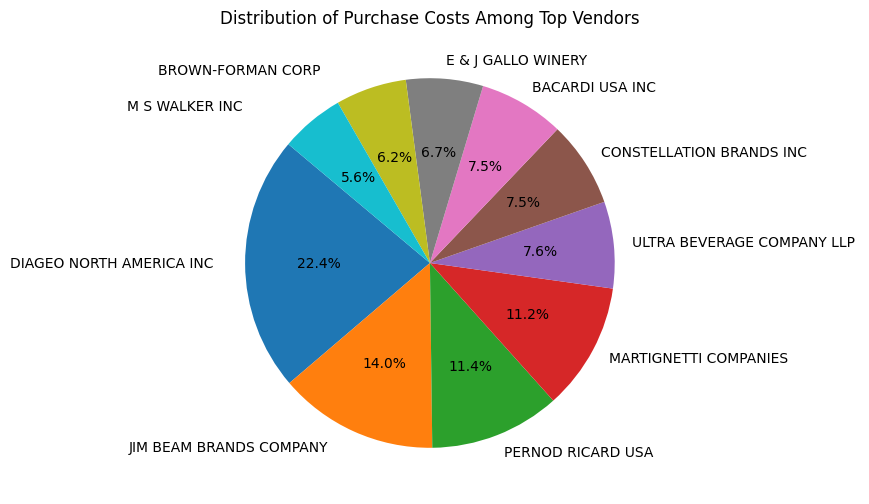

In [15]:
# Bar graph for top vendors by purchase cost
plt.figure(figsize=(10, 6))
top_vendors.plot(kind='bar', color='coral')
plt.title('Top 10 Vendors by Purchase Cost')
plt.ylabel('Purchase Cost')
plt.xlabel('Vendor Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Pie chart for distribution of purchase costs among the top vendors
plt.figure(figsize=(10, 6))
top_vendors.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchase Costs Among Top Vendors')
plt.ylabel('')  # to remove the default 'PurchasePrice' label from the y-axis
plt.show()

The bar chart illustrates the top 10 vendors by purchase cost. **We observe that "DIAGEO NORTH AMERICA INC" clearly dominates, with a significantly higher purchase cost compared to others.** The other vendors, like "JIM BEAM BRANDS COMPANY" and "PERNOD RICARD USA", have a more consistent distribution, showing a balanced spending across them.

Transitioning to the pie chart, which provides a distribution of purchase costs among top vendors, we get a more granular view. "DIAGEO NORTH AMERICA INC" accounts for 22.4% of the total purchase costs among the top vendors. The other vendors hold percentages ranging from 5.6% to 14%, indicating a more even distribution of costs among them.

In conclusion, while there's a dominant vendor in terms of purchase cost, the overall distribution among the top vendors is relatively even, with only a few outliers. This suggests a diversified vendor strategy, but with a few preferred partnerships.

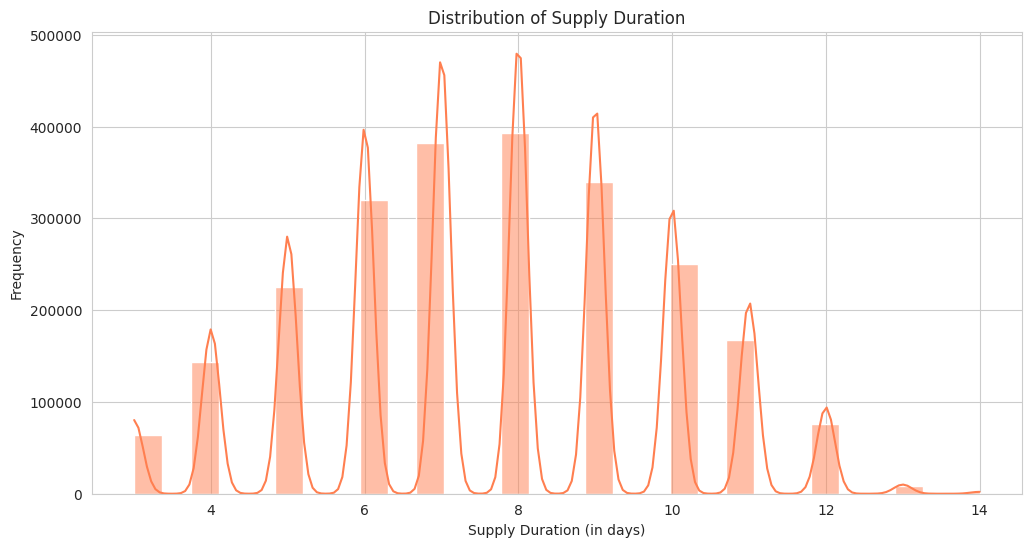

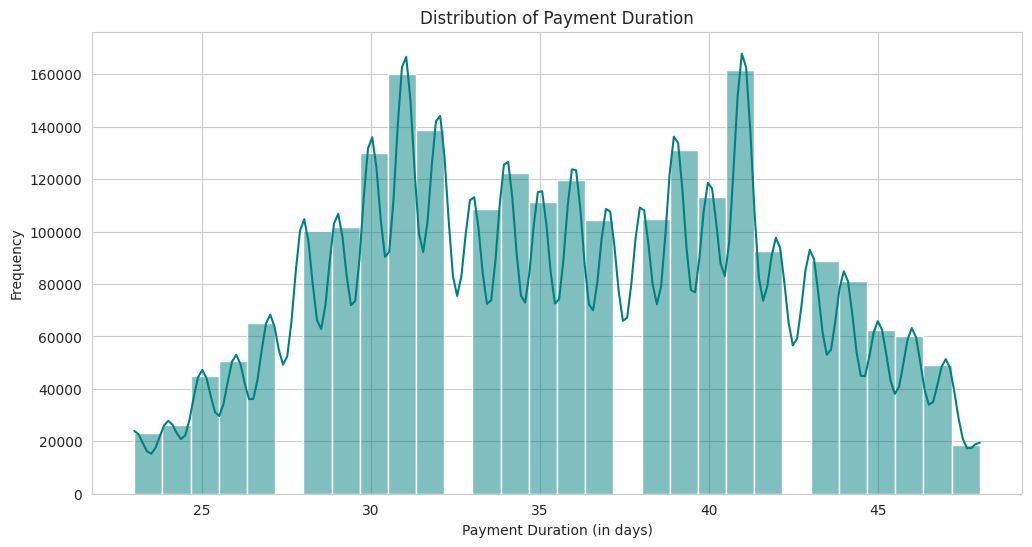

In [16]:
# Style settings
sns.set_style("whitegrid")

# Histogram for Supply Duration
plt.figure(figsize=(12, 6))
sns.histplot(purchases['SupplyDuration'], kde=True, bins=30, color='coral')
plt.title('Distribution of Supply Duration')
plt.xlabel('Supply Duration (in days)')
plt.ylabel('Frequency')
plt.show()

# Histogram for Payment Duration
plt.figure(figsize=(12, 6))
sns.histplot(purchases['PaymentDuration'], kde=True, bins=30, color='teal')
plt.title('Distribution of Payment Duration')
plt.xlabel('Payment Duration (in days)')
plt.ylabel('Frequency')
plt.show()


Here's some observations,
* The regular intervals observed in the supply duration chart suggest that there might be specific supply cycles or replenishment schedules that are adhered to.
* **Peaks in the supply distribution, particularly around 4, 6, 8, 10, and 12 days, might indicate standard supply contract durations or preferred restocking periods.**
* **The oscillation in payment durations, especially between 25 to 45 days, suggests variability in the terms of payment or potential inconsistencies in payment execution.**

In [17]:
start_date = sales['SalesDate'].min()
end_date = sales['SalesDate'].max()
total_days = (end_date - start_date).days

# Calculating Sales Velocity for each product
sales_velocity = sales.groupby(['Brand', 'Description']).agg(Total_Sales=('SalesQuantity', 'sum')).reset_index()
sales_velocity['Sales_Per_Day'] = sales_velocity['Total_Sales'] / total_days

purchases.loc[:, 'Lead_Time'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days
lead_times = purchases.groupby(['Brand', 'Description']).agg(Avg_Lead_Time=('Lead_Time', 'mean')).reset_index()

# Merging the data
merged_data = pd.merge(sales_velocity, lead_times, on=['Brand', 'Description'], how='left')

# Calculating Optimal Stock Level
merged_data['Optimal_Stock_Level'] = merged_data['Sales_Per_Day'] * merged_data['Avg_Lead_Time']

# Calculating Safety Stock using maximum sales for each product
max_sales = sales.groupby(['Brand', 'Description']).agg(Max_Daily_Sales=('SalesQuantity', 'max')).reset_index()
merged_data = pd.merge(merged_data, max_sales, on=['Brand', 'Description'], how='left')

merged_data['Safety_Stock'] = merged_data['Max_Daily_Sales'] - merged_data['Sales_Per_Day']
merged_data['Recommended_Stock_Level'] = merged_data['Optimal_Stock_Level'] + merged_data['Safety_Stock']




In [18]:
# Filtering products where Sales_Per_Day value is greater than Max_Daily_Sales value
problematic_products = merged_data[merged_data['Sales_Per_Day'] > merged_data['Max_Daily_Sales']]

# Getting the number of problematic products
num_problematic_products = len(problematic_products)

# Printing problematic products to the screen
print(f"There are {num_problematic_products} products where the Sales_Per_Day value is greater than the Max_Daily_Sales value.")
if num_problematic_products > 0:
    print(problematic_products[['Brand', 'Description', 'Sales_Per_Day', 'Max_Daily_Sales']])

There are 555 products where the Sales_Per_Day value is greater than the Max_Daily_Sales value.
      Brand                   Description  Sales_Per_Day  Max_Daily_Sales
7        77   Three Olives Espresso Vodka      15.389831                8
8        79      Three Olives Loopy Vodka       7.050847                5
76      273      Sauza Extra Gold Tequila      10.372881                9
139     482              Absolut 80 Proof      37.135593               23
142     497        Capt Morgan Spiced Rum      39.644068               38
...     ...                           ...            ...              ...
7426  44712    Sonoma-Cutrer Chard Sonoma      27.610169               25
7580  46379  Ghost Pine Cab Svgn LMartini      14.474576               12
7590  46447         Gascon Malbec Mendoza      22.796610               16
7592  46458      Layer Cake Barosa Shiraz       7.305085                7
7594  46476          Tilia Malbec Mendoza      26.169492               19

[555 rows x 4 c

In [19]:
# Updating Max_Daily_Sales for problematic products
merged_data.loc[merged_data['Sales_Per_Day'] > merged_data['Max_Daily_Sales'], 'Max_Daily_Sales'] = merged_data['Sales_Per_Day']

# Updating Safety Stock and Recommended Stock Level after modifying Max_Daily_Sales
merged_data['Safety_Stock'] = merged_data['Max_Daily_Sales'] - merged_data['Sales_Per_Day']
merged_data['Recommended_Stock_Level'] = merged_data['Optimal_Stock_Level'] + merged_data['Safety_Stock']

In an inventory management context, the Sales_Per_Day represents the average number of units sold per day, whereas the Max_Daily_Sales represents the highest number of units sold in a single day for a given product. Logically, the Max_Daily_Sales should never be lower than the Sales_Per_Day, as this would imply that the average daily sales are higher than the highest sales ever recorded for a single day, which is contradictory.

The occurrence of such a situation could be due to various reasons, including data entry errors, outliers, or computational errors. In our dataset, we observed that there were 555 products with this inconsistency.

To rectify this, we updated the Max_Daily_Sales value to be equal to the Sales_Per_Day value for these problematic products. This ensures that the Max_Daily_Sales is at least as large as the average daily sales, thereby maintaining logical consistency in the dataset.

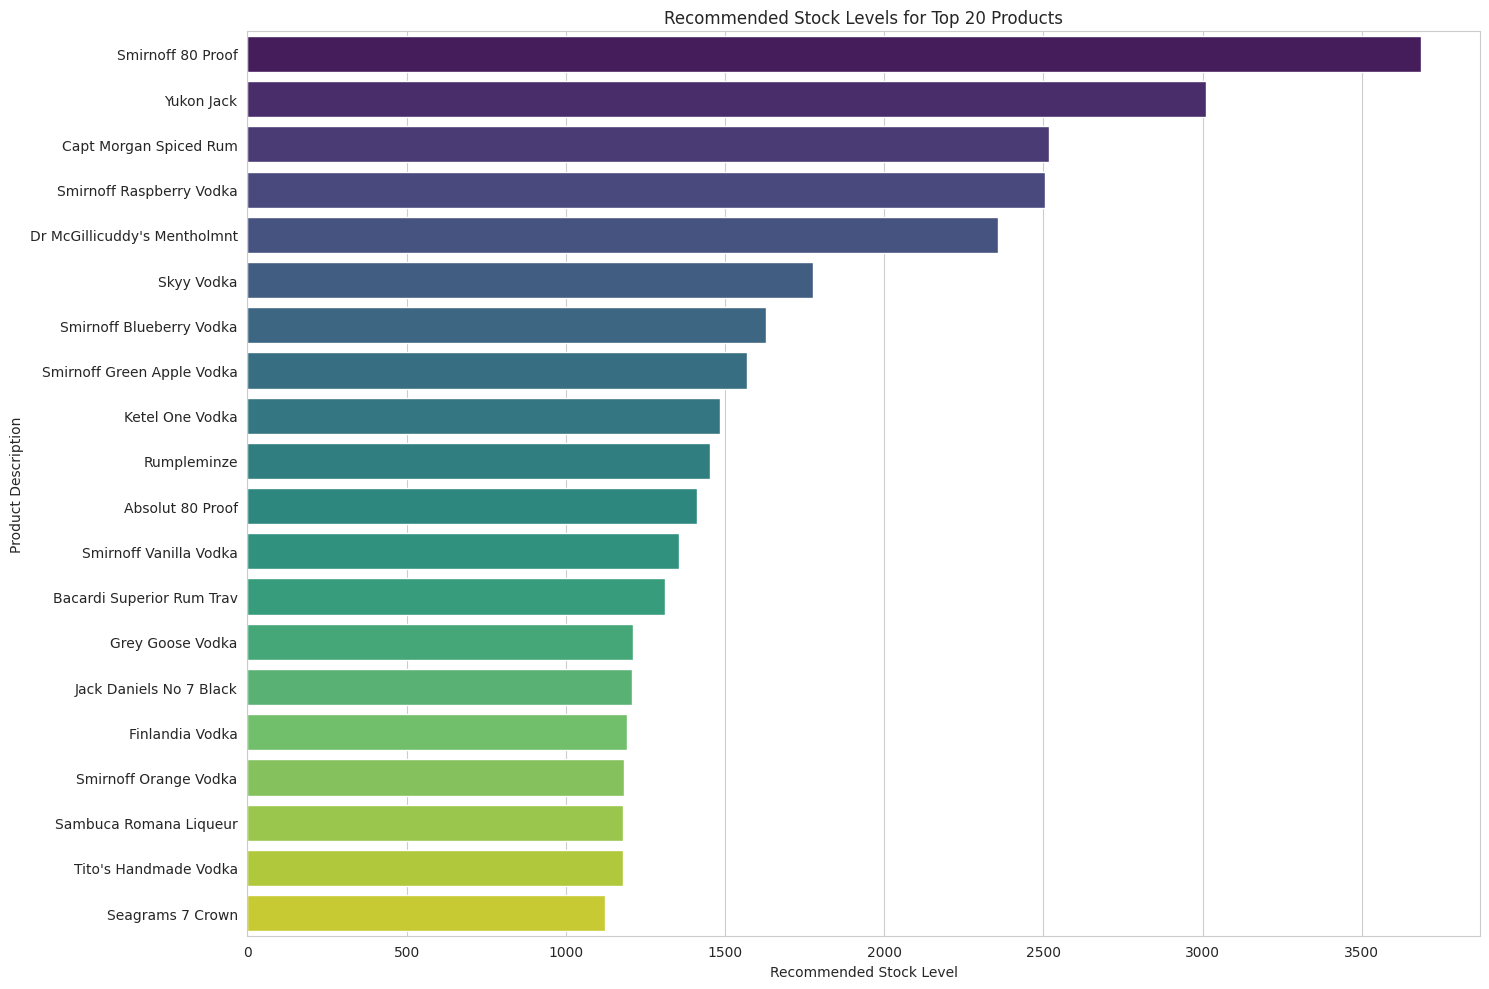

In [20]:
# Sorting the data by Recommended_Stock_Level for better visualization
sorted_data = merged_data.sort_values(by='Recommended_Stock_Level', ascending=False)

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='Recommended_Stock_Level', y='Description', data=sorted_data.head(20), palette='viridis')  # showing top 20 products for better visualization
plt.xlabel('Recommended Stock Level')
plt.ylabel('Product Description')
plt.title('Recommended Stock Levels for Top 20 Products')
plt.tight_layout()
plt.show()

The bar chart visually represents the recommended stock levels for the top 20 products. "Smirnoff 80 Proof" stands out as the product with the highest suggested stock level, indicating it has a high sales velocity and/or longer lead times. Conversely, products at the bottom of the chart like "Sambuca Romana Liqueur" have comparatively lower recommended stock levels. This visualization helps in quick decision-making regarding inventory replenishment and allocation.

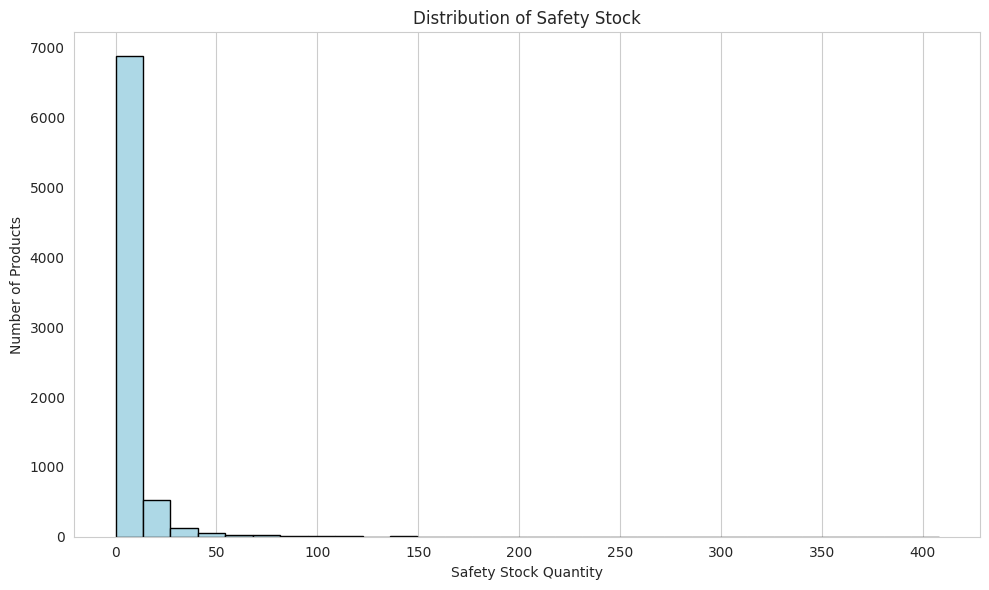

In [21]:
# Plotting the histogram for Safety Stock distribution
plt.figure(figsize=(10,6))
plt.hist(merged_data['Safety_Stock'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Safety Stock')
plt.xlabel('Safety Stock Quantity')
plt.ylabel('Number of Products')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The histogram illustrates the distribution of safety stock quantities across products. Most noticeably, a significant majority of products have their safety stock quantities clustered around zero. This means that for many products, there is either no safety stock or a very minimal amount.

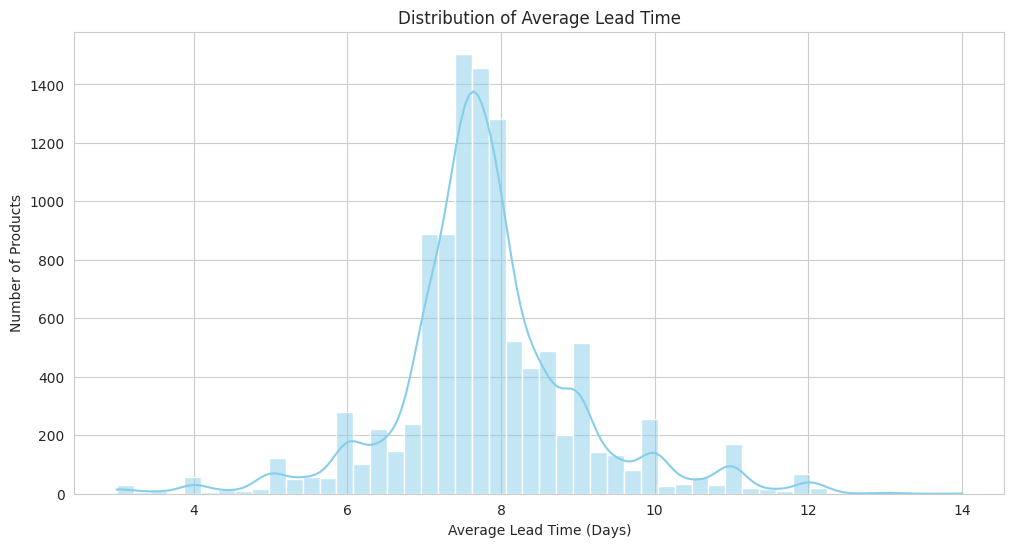

In [22]:
# Styling
sns.set_style("whitegrid")

# Creating the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=lead_times, x='Avg_Lead_Time', bins=50, color='skyblue', kde=True)
plt.title('Distribution of Average Lead Time')
plt.xlabel('Average Lead Time (Days)')
plt.ylabel('Number of Products')
plt.show()

The histogram illustrates the distribution of average lead times for products. The peak around 8 days suggests that most products have an average lead time of approximately 8 days. There are also some products with shorter or longer lead times, as seen in the spread between 4 to 14 days. The smooth line (Kernel Density Estimation) provides a clearer view of the distribution's shape, confirming the concentration around the 8-day mark.

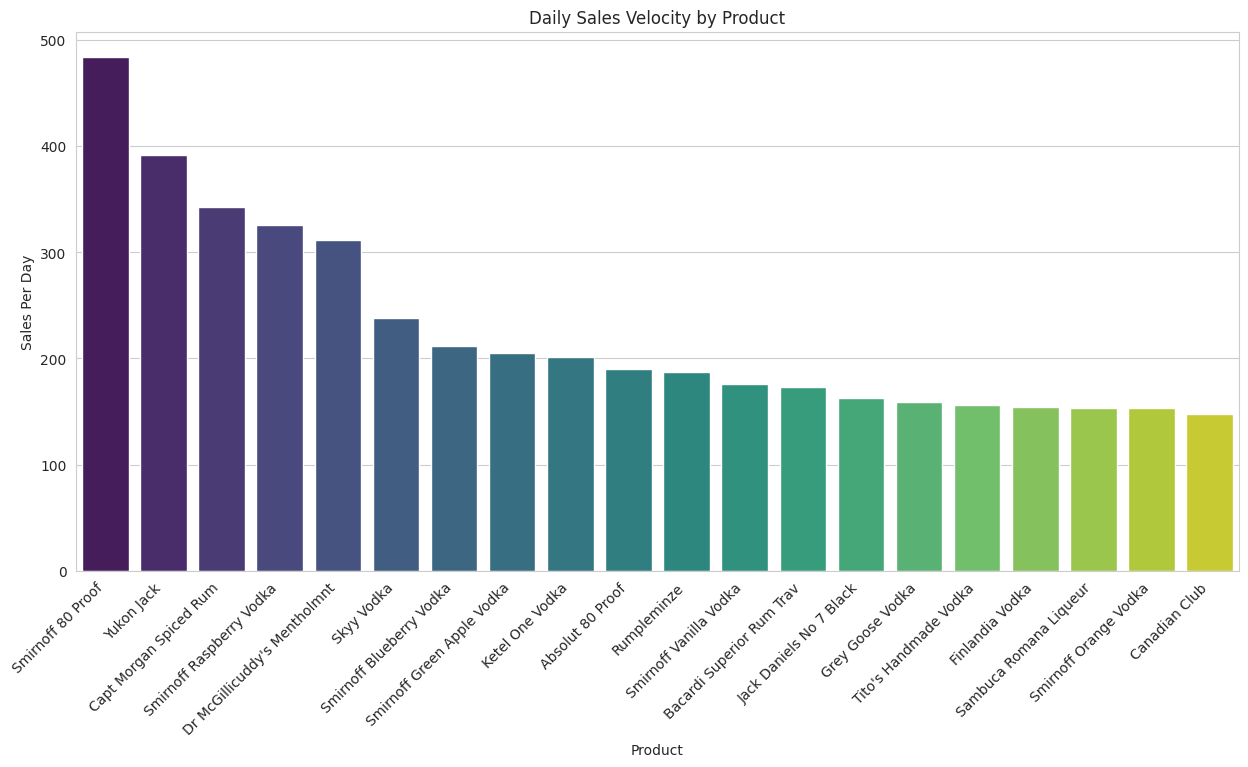

In [23]:
# Sorting the data by Sales_Per_Day in descending order to get top products
top_products = sales_velocity.sort_values(by='Sales_Per_Day', ascending=False).head(20)  # you can adjust the number as needed

# Creating the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='Description', y='Sales_Per_Day', data=top_products, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Daily Sales Velocity by Product')
plt.xlabel('Product')
plt.ylabel('Sales Per Day')
plt.show()

This bar chart showcases the daily sales velocity of various products. At a glance, it's evident that "Smirnoff 80 Proof" has the highest sales per day, significantly outpacing other products. As we move to the right of the chart, the sales per day for each product decreases, indicating a descending order of popularity or demand. The varying shades of color from dark to light also emphasize this declining trend in sales velocity. It provides valuable insights for inventory management, helping businesses prioritize which products to stock more frequently based on their sales rate.

**5. Optimal Stock Level Calculation**

      Brand                   Description  Current_Stock  \
0        58   Gekkeikan Black & Gold Sake          385.0   
1        60        Canadian Club 1858 VAP          146.0   
2        61         Margaritaville Silver           12.0   
3        62      Herradura Silver Tequila          459.0   
4        63    Herradura Reposado Tequila          442.0   
...     ...                           ...            ...   
7653  90084  Les Fiefs Lagrange St Jul 11            2.0   
7654  90085  Ch Lilian 09 Ladouys St Este            6.0   
7655  90086  La Dame Montrose St Estep 11           32.0   
7656  90087  Ch Mouton Rothschild 12 Paui           45.0   
7657  90089    Ch Lynch Bages 12 Pauillac          124.0   

      Recommended_Stock_Level  Order_Quantity  
0                   39.990104        0.000000  
1                   16.996855        0.000000  
2                   14.894394        2.894394  
3                   20.384988        0.000000  
4                   18.042373        0.

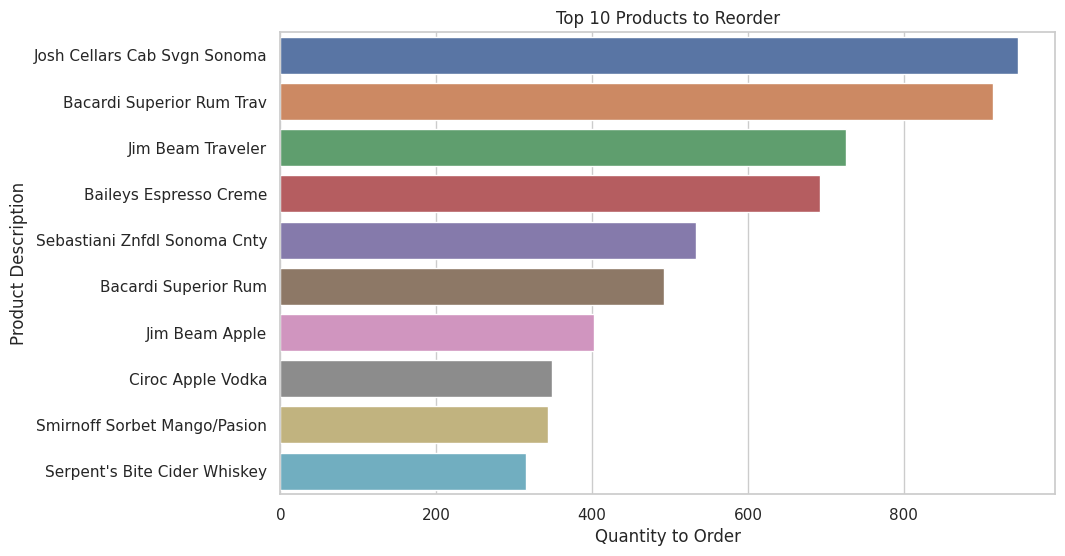

In [24]:
end_inv['endDate'] = pd.to_datetime(end_inv['endDate'])
latest_inventory_date = end_inv['endDate'].max()
current_inventory = end_inv[end_inv['endDate'] == latest_inventory_date]

# Summarizing the current stock levels by product.
current_stock_levels = current_inventory.groupby(['Brand', 'Description']).agg(Current_Stock=('onHand', 'sum')).reset_index()

# Merging the current stock levels with the previously calculated data.
final_data = pd.merge(merged_data, current_stock_levels, on=['Brand', 'Description'], how='left')

# Assume zero current stock for any products not present in the current inventory.
final_data['Current_Stock'] = final_data['Current_Stock'].fillna(0)

# Calculating how much of each product needs to be ordered if current stock is below recommended levels.
final_data['Order_Quantity'] = final_data['Recommended_Stock_Level'] - final_data['Current_Stock']
final_data['Order_Quantity'] = final_data['Order_Quantity'].clip(lower=0)  # Setting negative order quantities to zero.

# Reporting the results.
print(final_data[['Brand', 'Description', 'Current_Stock', 'Recommended_Stock_Level', 'Order_Quantity']])


# Creating a graph using Seaborn.
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Order_Quantity', y='Description', data=final_data.sort_values('Order_Quantity', ascending=False).head(10))
plt.title('Top 10 Products to Reorder')
plt.xlabel('Quantity to Order')
plt.ylabel('Product Description')
plt.show()


The bar graph displays the top 10 products that need to be reordered based on inventory data. The products are sorted by the quantity that needs to be ordered, **which is determined by the difference between the recommended stock levels and the current stock on hand.** If the current stock is below the recommended level, the product appears on the list with the quantity to order represented on the x-axis.

From the graph, we can observe the following:

* The product "Josh Cellars Cab Svgn Sonoma" has the highest quantity to reorder, approaching the 800-unit mark.
* "Bacardi Superior Rum Trav" and "Jim Beam Traveler" follow next with slightly less quantity to order, both near or above the 600-unit mark.
* Other products like "Baileys Espresso Creme" and "Sebastiani Znfdl Sonoma Cnty" are in the middle range with quantities to order around 400 units.
* The product with the least quantity to reorder among the top 10 is "Serpent's Bite Cider Whiskey," which is just below the 200-unit mark.


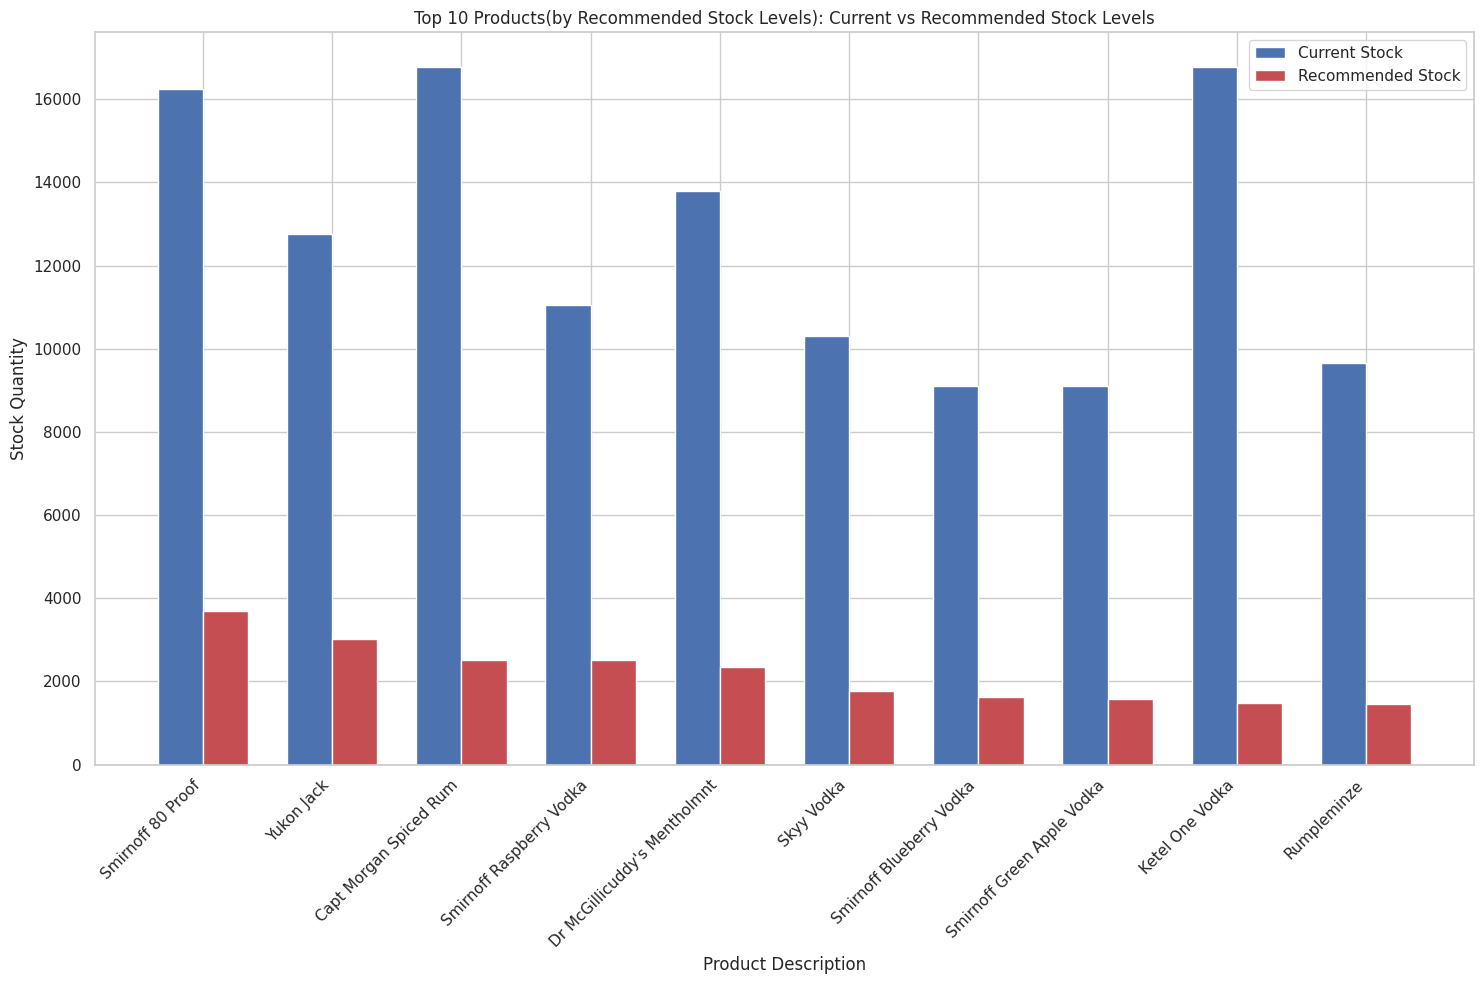

In [25]:
# Sorting the products by recommended stock level
sorted_data = final_data.sort_values(by='Recommended_Stock_Level', ascending=False).head(10)  # To show the top 10 products

# Creating a double-column bar chart
bar_width = 0.35
index = np.arange(len(sorted_data))

plt.figure(figsize=(15, 10))
bar1 = plt.bar(index, sorted_data['Current_Stock'], bar_width, label='Current Stock', color='b')
bar2 = plt.bar([i + bar_width for i in index], sorted_data['Recommended_Stock_Level'], bar_width, label='Recommended Stock', color='r')

# Setting the labels and title
plt.xlabel('Product Description')
plt.ylabel('Stock Quantity')
plt.title('Top 10 Products(by Recommended Stock Levels): Current vs Recommended Stock Levels')
plt.xticks([i + bar_width / 2 for i in index], sorted_data['Description'], rotation=45, ha='right')
plt.legend()

# Displaying the chart
plt.tight_layout()
plt.show()




**This inventory review highlights a significant surplus in the current stock levels when compared with the recommended stock levels for the top 10 products, sorted by the recommended quantity.** Notably, "Ketel One Vodka" and "Rumpleminze" showcase a pronounced excess beyond the suggested inventory, suggesting inefficiencies in stock management. The presence of stock quantities exceeding recommended levels across all observed items may lead to higher carrying costs and risk of stock becoming outdated. Immediate measures such as revising purchase orders and aligning with sales projections are advised to mitigate the risks associated with overstocking and to optimize the stock turnover ratio.

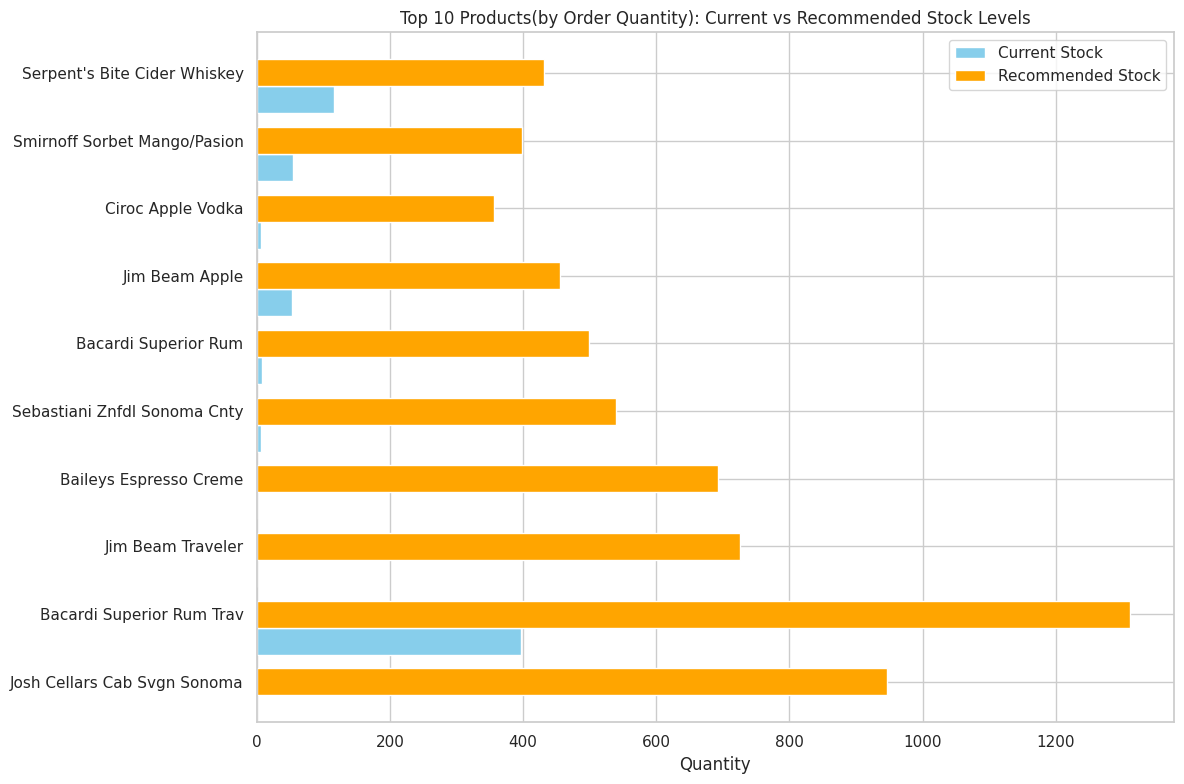

In [26]:
# Filtering the data to show the top 10 products where the ordering quantity is highest
top_products_to_order = final_data.nlargest(10, 'Order_Quantity')

# Plotting the bars
fig, ax = plt.subplots(figsize=(12, 8))

# Indexing for the bars
ind = np.arange(len(top_products_to_order))

# Width of the bars
bar_width = 0.4

# Plotting current stock and recommended stock side by side
ax.barh(ind, top_products_to_order['Current_Stock'], bar_width, color='skyblue', label='Current Stock')
ax.barh([i + bar_width for i in ind], top_products_to_order['Recommended_Stock_Level'], bar_width, color='orange', label='Recommended Stock')

# Setting the y-axis labels to product descriptions
ax.set(yticks=[i + bar_width for i in ind], yticklabels=top_products_to_order['Description'], ylim=[2 * bar_width - 1, len(ind)])

# Adding the legend
ax.legend()

# Adding labels and title
ax.set_xlabel('Quantity')
ax.set_title('Top 10 Products(by Order Quantity): Current vs Recommended Stock Levels')

# Display the plot
plt.tight_layout()
plt.show()



The graph titled "Top 10 Products (by Order Quantity): Current vs Recommended Stock Levels" shows that for all top-selling 10 products, the current stock (blue) is below the recommended stock levels (orange), indicating a need for restocking to meet the suggested inventory.

**Conclusion**

**Top Products & Trends:**  
* **"Ketel One Vodka" soared from 4th to the top, hinting at surging demand.**
* "Capt Morgan Spiced Rum" finished a close second, just one unit behind.
* "Smirnoff 80 Proof" held its ground despite a rebranding, shifting from number 3876 to 8111.
* "Absolut 80 Proof" slightly dropped in rank, remaining strong.
* Newcomer "Jack Daniels No 7 Black" broke into the top 5.  

**Inventory Challenges:**
* **Zero inventory items at year's start and end suggest stocking or demand issues.**
* Low-stock items show unpredictable inventory levels.
* **Specialty items, like select wines, linger at the bottom, indicating niche demand.**

**Inventory Management Insights:**
* **Strong consistency in top products reflects solid demand forecasting and replenishment.**
* **Recurring zero stock levels could point to deeper inventory procurement flaws.**
* **Sales peaked notably on January 25th, then stabilized in February.**
* **DIAGEO NORTH AMERICA INC dominated vendor purchases** with $3.9 million, significantly ahead of others.
* **Average supply duration is 7.62 days, but average payment stretches to 35.66 days.**


**Operational Data Points:**  
* Data corrections were made for 555 products to align Max_Daily_Sales with Sales_Per_Day.
* **"Smirnoff 80 Proof" leads the recommended stock levels.**
* Majority of products have minimal safety stock, implying tight inventory control.
* **Lead times peak around 8 days.**
* Daily sales velocity shows "Smirnoff 80 Proof" far ahead, emphasizing its high demand.

**Stocking Strategies:**
* "Josh Cellars Cab Svgn Sonoma" requires the most restocking, nearly 800 units.
* **For the top ten products with the highest recommended stock levels, still current stock levels exceed recommended levels, hinting at overstocking and a need for inventory adjustment.**
*  **There is a clear necessity to replenish the inventory for the most ordered 10 products to meet the recommended stock levels and ensure adequate supply to match demand.**
* In essence, top-selling spirits demonstrate strong market demand with effective inventory turns, while zero-stock items and niche products present opportunities for inventory optimization. A significant sales event occurs in late January, and the payment terms to vendors may require review. Inventory discrepancies are being addressed, and a focus on high-velocity products like "Smirnoff 80 Proof" is evident. The strategy includes refining restocking practices to avoid excess inventory and associated costs.